# PyAnsys Geometry 101: Modeling

Once you understand PyAnsys Geometry's mathematical constructs, units, and sketching capabilities,
you can dive into its modeling capabilities.

PyAnsys Geometry is a Python client that connects to a modeling service. Here are the modeling
services that are available for connection:

- **DMS**: Windows-based modeling service that has been containerized to ease
  distribution, execution, and remotability operations.
- **Geometry service**: Linux-based approach of DMS that is currently under development.
- **Ansys Discovery and SpaceClaim**: PyAnsys Geometry is capable of connecting to a running session
  of Ansys Discovery or SpaceClaim. Although this is not the main use case for PyAnsys Geometry,
  a connection to one of these Ansys products is possible. Because these products have
  graphical user interfaces, performance is not as high with this option as with the previous
  options. However, connecting to a running instance of Discovery or SpaceClaim might be
  useful for some users.

## Launch a modeling service

While the PyAnsys Geometry operations in earlier examples did not require communication with
a modeling service, this example requires that a modeling service is available. All subsequent
examples also require that a modeling service is available.

Launch a modeling service session.

In [1]:
from ansys.geometry.core import launch_modeler

# Start a modeler session
modeler = launch_modeler()
print(modeler)

Ansys Geometry Modeler (0x2d17fc6cc40)

Ansys Geometry Modeler Client (0x2d17fc6ccd0)
  Target:     localhost:700
  Connection: Healthy


You can also launch your own services and connect to them. For information on
connecting to an existing service, see the
[Modeler API](https://geometry.docs.pyansys.com/version/stable/api/ansys/geometry/core/modeler/Modeler.html#Modeler)
documentation.

Here is how the class architecture is implemented:

* ``Modeler``: Handler object for the active service session. This object allows you
  to connect to an existing service by passing in a host and a port. It also
  allows you to create ``Design`` objects, which is where the modeling takes
  place. For more information, see the [Modeler API](https://geometry.docs.pyansys.com/version/stable/api/ansys/geometry/core/modeler/Modeler.html#Modeler)
  documentation.
* ``Design``: Root object of your assembly (tree). While a ``Design`` object is also a
  ``Component`` object, it has enhanced capabilities, including creating named selections,
  adding materials, and handling beam profiles. For more information, see the
  [Design API](https://geometry.docs.pyansys.com/version/stable/api/ansys/geometry/core/designer/design/Design.html#Design)
  documentation.
* ``Component``: One of the main objects for modeling purposes. ``Component`` objects
  allow you to create bodies, subcomponents, beams, design points, planar surfaces, and more.
  For more information, see the [Component API](https://geometry.docs.pyansys.com/version/stable/api/ansys/geometry/core/designer/component/Component.html#Component)
  documentation.

The following code examples show how you use these objects.
More capabilities of these objects are shown in the specific
example sections for sketching and modeling.

## Create and plot a sketch

Create a ``Sketch`` object and plot it.

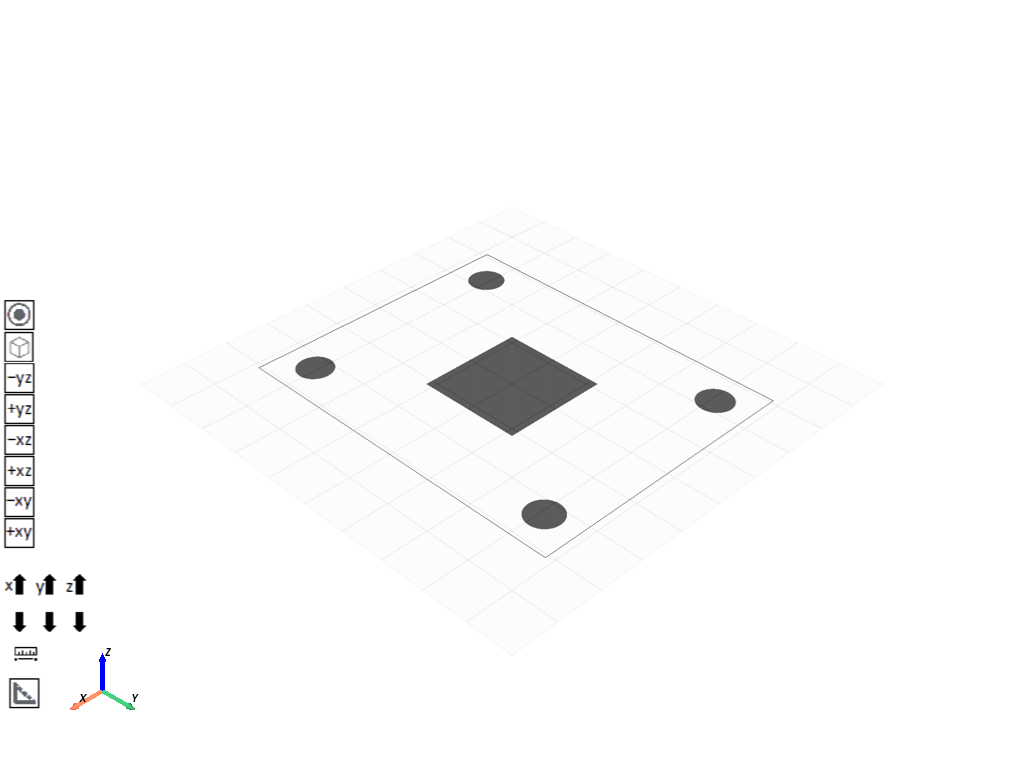

In [2]:
from ansys.geometry.core.sketch import Sketch
from ansys.geometry.core.math import Point2D
from ansys.geometry.core.misc import UNITS, Distance

outer_hole_radius = Distance(0.5, UNITS.m)

sketch = Sketch()
(
    sketch.segment(start=Point2D([-4, 5], unit=UNITS.m), end=Point2D([4, 5], unit=UNITS.m))
    .segment_to_point(end=Point2D([4, -5], unit=UNITS.m))
    .segment_to_point(end=Point2D([-4, -5], unit=UNITS.m))
    .segment_to_point(end=Point2D([-4, 5], unit=UNITS.m))
    .box(
        center=Point2D([0, 0], unit=UNITS.m),
        width=Distance(3, UNITS.m),
        height=Distance(3, UNITS.m),
    )
    .circle(center=Point2D([3, 4], unit=UNITS.m), radius=outer_hole_radius)
    .circle(center=Point2D([-3, -4], unit=UNITS.m), radius=outer_hole_radius)
    .circle(center=Point2D([-3, 4], unit=UNITS.m), radius=outer_hole_radius)
    .circle(center=Point2D([3, -4], unit=UNITS.m), radius=outer_hole_radius)
)

# Plot the sketch
sketch.plot()

## Perform some modeling operations

Now that the sketch is ready to be extruded, perform some modeling operations,
including creating the design, creating the body directly on the design, and
plotting the body.

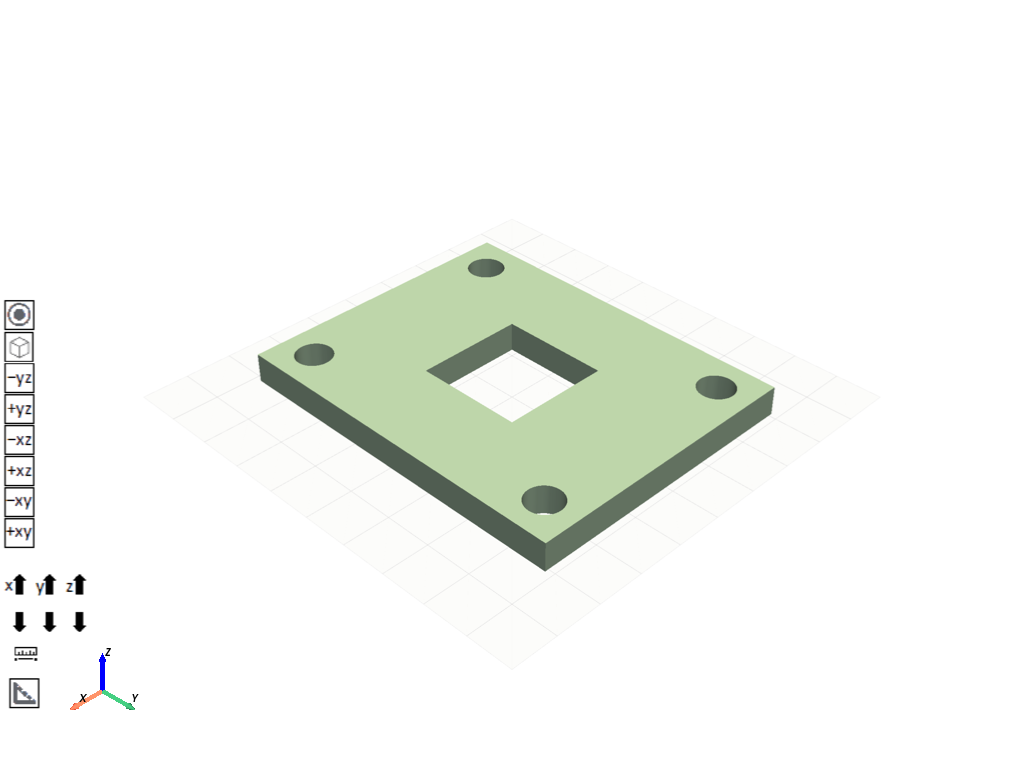

In [3]:
# Start by creating the Design
design = modeler.create_design("ModelingDemo")

# Create a body directly on the design by extruding the sketch
body = design.extrude_sketch(
    name="Design_Body", sketch=sketch, distance=Distance(80, unit=UNITS.cm)
)

# Plot the body
design.plot()

## Perform some operations on the body

Perform some operations on the body.

In [4]:
# Request its faces, edges, volume...
faces = body.faces
edges = body.edges
volume = body.volume

print(f"This is body {body.name} with ID (server-side): {body.id}.")
print(f"This body has {len(faces)} faces and {len(edges)} edges.")
print(f"The body volume is {volume}.")

This is body Design_Body with ID (server-side): 0:22.
This body has 14 faces and 32 edges.
The body volume is 54.28672587712816 meter ** 3.


Other operations that can be performed include adding a midsurface offset
and thickness (only for planar bodies), imprinting curves, assigning materials,
copying, and translating.

Copy the body on a new subcomponent and translate it.

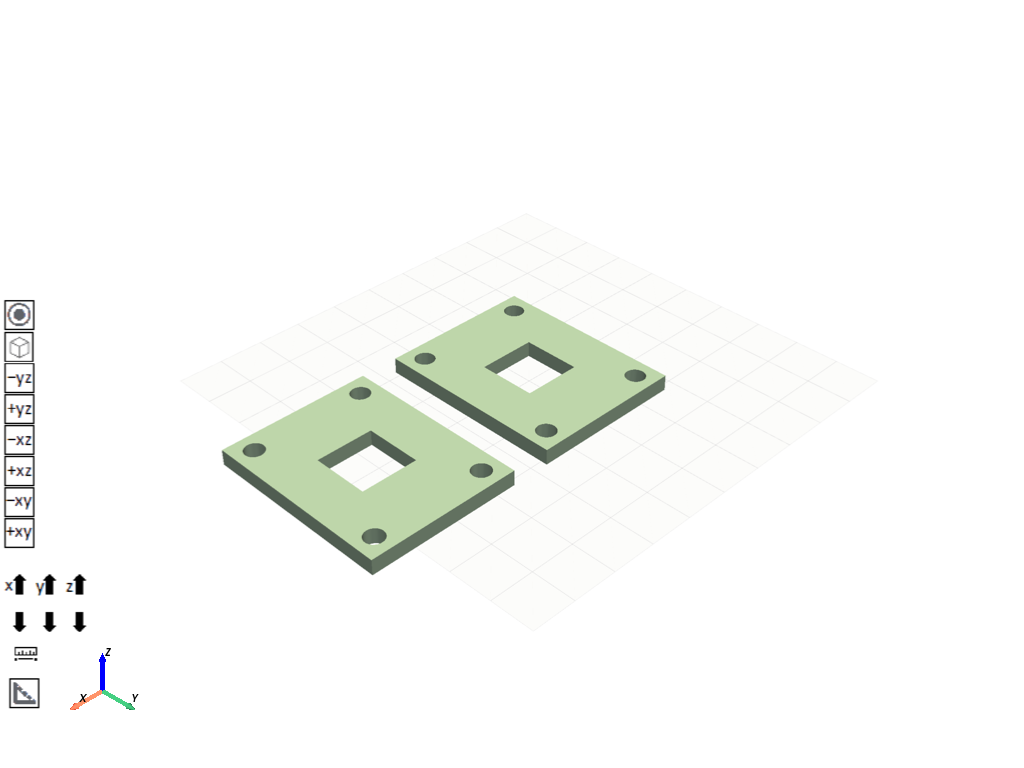

In [5]:
from ansys.geometry.core.math import UNITVECTOR3D_X

# Create a component
comp = design.add_component("Component")

# Copy the body that belongs to this new component
body_copy = body.copy(parent=comp, name="Design_Component_Body")

# Displace this new body by a certain distance (10m) in a certain direction (X-axis)
body_copy.translate(direction=UNITVECTOR3D_X, distance=Distance(10, unit=UNITS.m))

# Plot the result of the entire design
design.plot()

Create and assign materials to the bodies that were created.

In [6]:
from pint import Quantity

from ansys.geometry.core.materials import Material, MaterialProperty, MaterialPropertyType

# Define some general properties for the material.
density = Quantity(125, 10 * UNITS.kg / (UNITS.m * UNITS.m * UNITS.m))
poisson_ratio = Quantity(0.33, UNITS.dimensionless)
tensile_strength = Quantity(45)  # WARNING: If no units are defined,
#it is assumed that the magnitude is in the units expected by the server.

# Once your material properties are defined, you can easily create a material.
material = Material(
    "steel",
    density,
    [MaterialProperty(MaterialPropertyType.POISSON_RATIO, "PoissonRatio", poisson_ratio)],
)

# If you forgot to add a property, or you want to overwrite its value, you can still
# add properties to your created material.
material.add_property(
    type=MaterialPropertyType.TENSILE_STRENGTH, name="TensileProp", quantity=tensile_strength
)

# Once your material is properly defined, send it to the server.
# This material can then be reused by different objects
design.add_material(material)

# Assign your material to your existing bodies.
body.assign_material(material)
body_copy.assign_material(material)

Currently materials do not have any impact on the visualization when plotting
is requested, although this could be a future feature. If the final
assembly is open in Discovery or SpaceClaim, you can observe the changes.

## Create a named selection

PyAnsys Geometry supports the creation of a named selection via the ``Design`` object.

Create a named selection with some of the faces of the previous body
and the body itself.

In [7]:
# Create a named selection
faces = body.faces
ns = design.create_named_selection("MyNamedSelection", bodies=[body], faces=[faces[0], faces[-1]])
print(f"This is a named selection called {ns.name} with ID (server-side): {ns.id}.")

This is a named selection called MyNamedSelection with ID (server-side): 0:429.


## Perform deletions

Deletion operations for bodies, named selections, and components are possible,
always from the scope expected. For example, if you attempted to delete the original body
from a component that has no ownership over it (such as your ``comp`` object), the deletion
would fail. If you attempted to perform this deletion from the ``design`` object, the
deletion would succeed.

The next two code examples show how deletion works.

Is the body alive? True


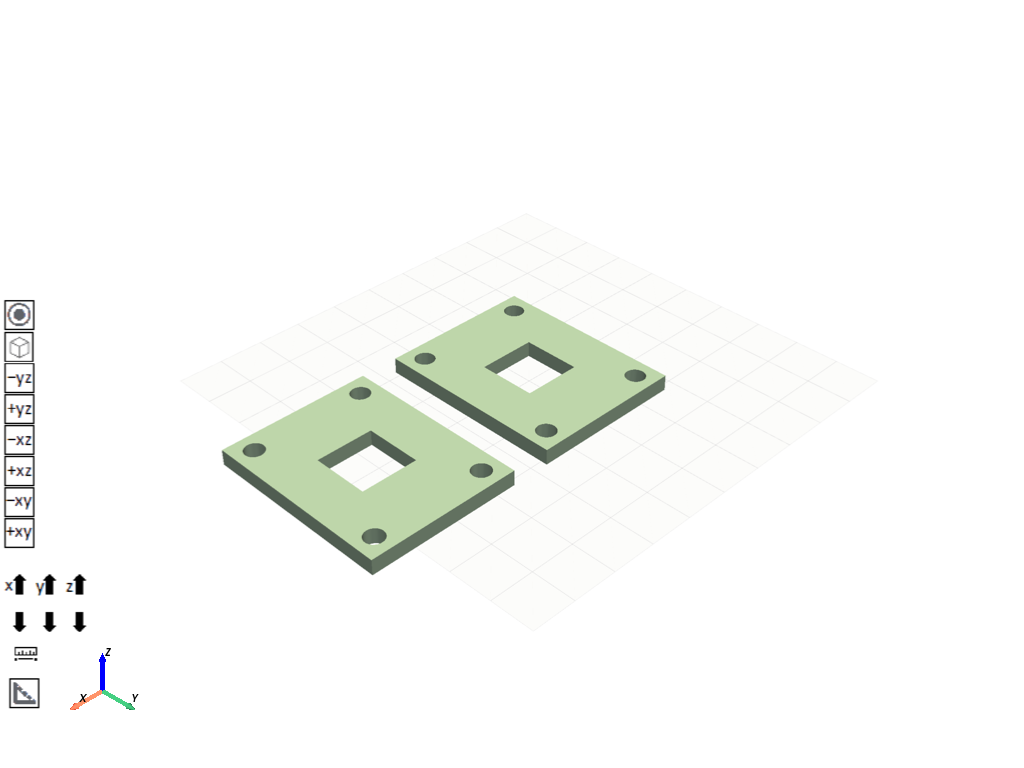

In [8]:
# If you try to delete this body from an "unauthorized" component, the deletion is not allowed.
comp.delete_body(body)
print(f"Is the body alive? {body.is_alive}")

# If you request a plot of the entire design, you can still see it.
design.plot()

Is the body alive? False


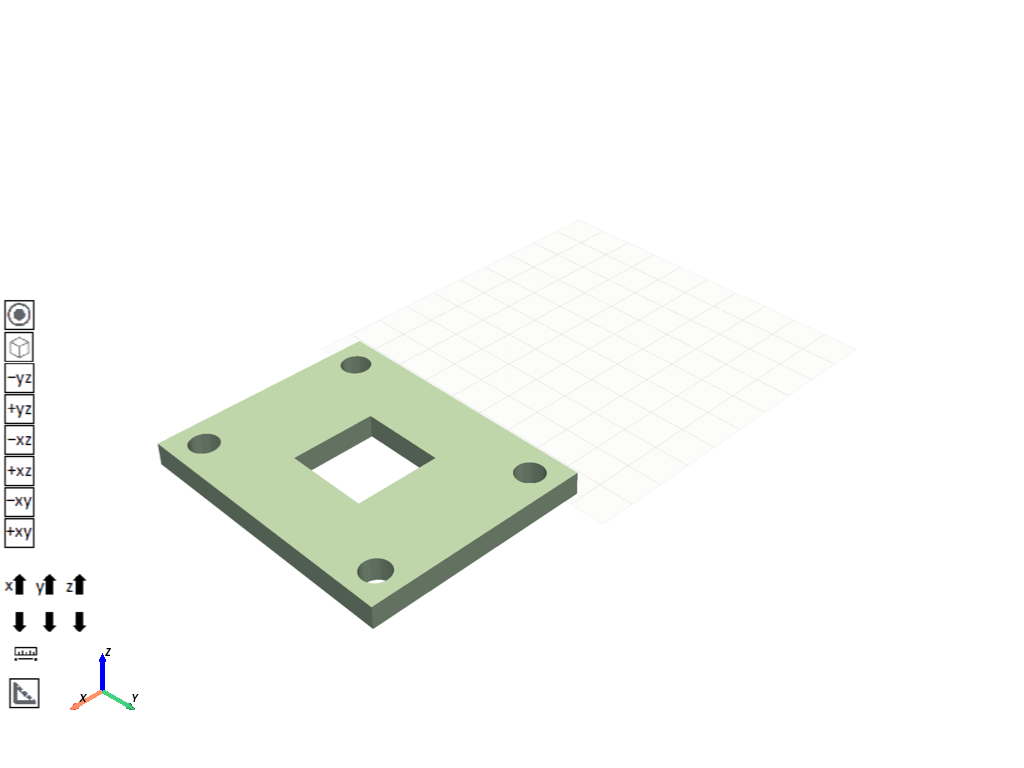

In [9]:
# Because the body belongs to the ``design`` object and not the ``comp`` object,
# deleting it from ``design`` object works.
design.delete_body(body)
print(f"Is the body alive? {body.is_alive}")

# If you request a plot of the entire design, it is no longer visible.
design.plot()

## Export files

Once modeling operations are finalized, you can export files
in different formats. For the formats supported by DMS, see the
[DesignFileFormat](https://geometry.docs.pyansys.com/version/stable/api/ansys/geometry/core/designer/design/DesignFileFormat.html#DesignFileFormat)
class in the ``Design`` module documentation.

Export files in SCDOCX and FMD formats.

In [10]:
import os
from pathlib import Path

from ansys.geometry.core.designer import DesignFileFormat

# Path to downloads directory
file_dir = Path(os.getcwd(), "downloads")
file_dir.mkdir(parents=True, exist_ok=True)

# Download the model in different formats
design.download(file_location=Path(file_dir, "ModelingDemo.scdocx"), format=DesignFileFormat.SCDOCX)
design.download(file_location=Path(file_dir, "ModelingDemo.fmd"), format=DesignFileFormat.FMD)

## Close session

When you finish interacting with your modeling service, you should close the active
server session. This frees resources wherever the service is running.

Close the server session.

In [11]:
modeler.close()

.. note::
   If the server session already existed (that is, it was not launched by
   the current client session), you cannot use this method to close the
   server session. You must manually close the server serssion instead.
   This is a safeguard for user-spawned services.